# Enhancing NHL Salary Evaluation through Dimensionality Reduction  
Raphaël Fontaine  
McGill University  
Montreal, Canada  
raphael.fontaine@mail.mcgill.ca  

# Partial Least Squares (PLS)

In [1]:
import common
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cross_decomposition import PLSRegression

In [2]:
df = common.load_dataset()

# Split features and label
X_data, y_data = common.split_dataset(df)

X_columns = X_data.columns

# Split train and test data
X_train, y_train, X_test, y_test = common.split_train_test(X_data, y_data)

# Standardize the features
X_train, X_test = common.standard_scaler(X_train, X_test)

## PLS Implementation

In [3]:
def PLS(n_components):
    X = X_train.astype(np.float64)
    n_samples, n_features = X.shape

    # Reshape y to column vector of floats
    y = y_train.reshape(-1, 1).astype(np.float64)

    # Initialize matrices full of zeros
    T = np.zeros((n_samples, n_components))     # Components
    W = np.zeros((n_features, n_components))    # Weights
    P = np.zeros((n_features, n_components))    # Loadings for X
    Q = np.zeros(n_components)                  # Loadings for y

    for i in range(n_components):
        # Compute weights w that maximize covariance between X and y
        w = X.T @ y
        w /= np.linalg.norm(w)  # Normalize to unit length
        
        # Project X onto w to find t
        t = X @ w
        
        tk = (t.T @ t)

        # Compute loadings p
        p = (X.T @ t) / tk
        
        # Compute loadings q
        q = (y.T @ t) / tk
        q = q.item()  # Convert to scalar
        
        # Deflate X and y
        X -= t @ p.T
        y -= q * t
        
        # Store results
        T[:, i] = t.ravel()
        P[:, i] = p.ravel()
        W[:, i] = w.ravel()
        Q[i] = q
    
    return T, W, P, Q

In [4]:
n_components = [5, 10, 25, 50, 100, 200]

results = []
PLS_results = []
for n in n_components:

    # Perform PLS and apply to the data
    T, W, P, Q = PLS(n)
    PLS_results.append((T, W, P, Q))

    X_train_pls = X_train @ W
    X_test_pls = X_test @ W

    # Train and evaluate the models
    results_df, predictions = common.train_and_evaluate(X_train_pls, y_train, X_test_pls, y_test)

    results_df["Components"] = n

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Components")[results_df.columns].apply(lambda x: x).drop(columns=["Components"])

R2        MAE Top-100 MAE Top-50 MAE  \
Components Model                                                           
5          Linear Regression    0.5871  1,301,688   1,884,016  2,420,104   
           Random Forest        0.5695  1,344,141   1,906,363  2,408,968   
           Support Vector       0.5950  1,283,262   1,873,306  2,402,444   
           K-Nearest Neighbors  0.5738  1,343,160   1,860,158  2,282,809   
10         Linear Regression    0.5733  1,325,284   1,842,915  2,280,512   
           Random Forest        0.5467  1,388,011   1,913,015  2,581,870   
           Support Vector       0.5976  1,283,728   1,805,279  2,261,418   
           K-Nearest Neighbors  0.5620  1,325,035   1,858,557  2,353,879   
25         Linear Regression    0.5345  1,377,533   1,772,794  2,163,478   
           Random Forest        0.5276  1,428,605   1,997,287  2,689,512   
           Support Vector       0.5994  1,274,635   1,849,491  2,340,399   
           K-Nearest Neighbors  0.5745  1,316,685   1,860,251  2,416,610   
50         Linear Regression    0.5159  1,407,256   1,916,936  2,332,747   
           Random Forest        0.4977  1,506,085   2,209,466  2,938,098   
           Support Vector       0.5956  1,279,232   1,893,485  2,395,726   
           K-Nearest Neighbors  0.5683  1,335,935   1,910,936  2,448,318   
100        Linear Regression    0.5101  1,416,501   1,888,406  2,281,440   
           Random Forest        0.4433  1,572,835   2,448,338  3,266,438   
           Support Vector       0.5900  1,286,268   1,883,272  2,400,313   
           K-Nearest Neighbors  0.5605  1,348,836   2,022,288  2,561,082   
200        Linear Regression    0.5051  1,435,270   1,967,415  2,346,021   
           Random Forest        0.4117  1,631,209   2,573,281  3,493,959   
           Support Vector       0.5864  1,289,766   1,888,387  2,409,532   
           K-Nearest Neighbors  0.5542  1,359,316   1,996,245  2,549,803   

                                 SMAPE  Train time (sec)  
Components Model                                          
5          Linear Regression    0.3348              0.00  
           Random Forest        0.3437              1.40  
           Support Vector       0.3271              0.53  
           K-Nearest Neighbors  0.3459              0.02  
10         Linear Regression    0.3386              0.11  
           Random Forest        0.3543              1.81  
           Support Vector       0.3238              0.49  
           K-Nearest Neighbors  0.3402              0.00  
25         Linear Regression    0.3490              0.05  
           Random Forest        0.3629              2.86  
           Support Vector       0.3216              0.70  
           K-Nearest Neighbors  0.3376              0.00  
50         Linear Regression    0.3609              0.12  
           Random Forest        0.3812              4.18  
           Support Vector       0.3227              0.97  
           K-Nearest Neighbors  0.3429              0.00  
100        Linear Regression    0.3647              1.78  
           Random Forest        0.3957              6.74  
           Support Vector       0.3244              0.98  
           K-Nearest Neighbors  0.3446              0.00  
200        Linear Regression    0.3679              1.26  
           Random Forest        0.4084              8.14  
           Support Vector       0.3248              0.95  
           K-Nearest Neighbors  0.3446              0.00

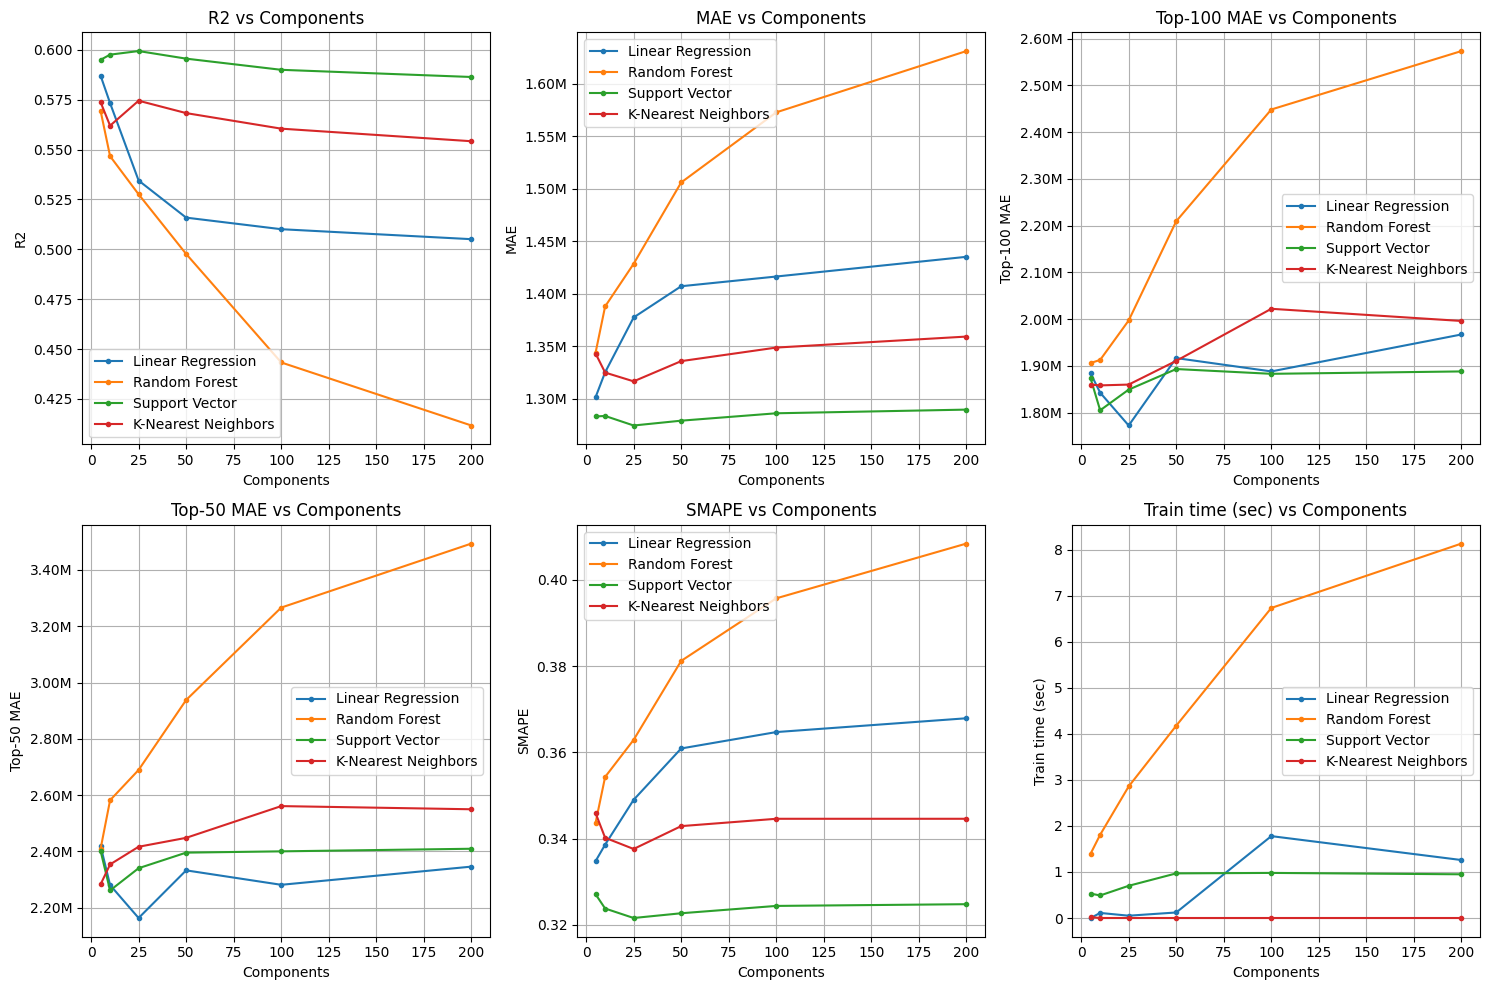

In [5]:
common.plot_metrics(results_df, "Components")

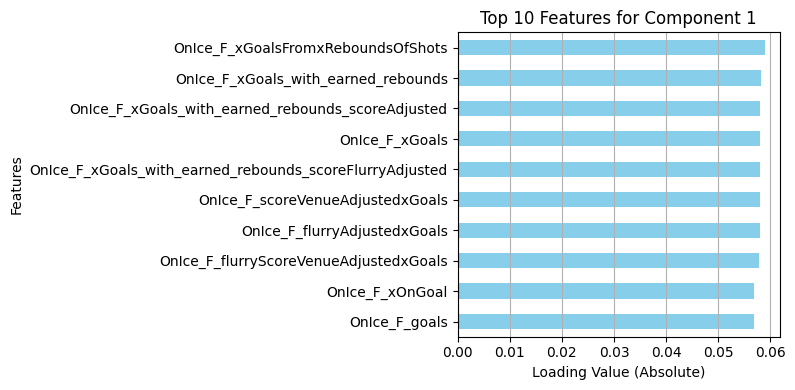

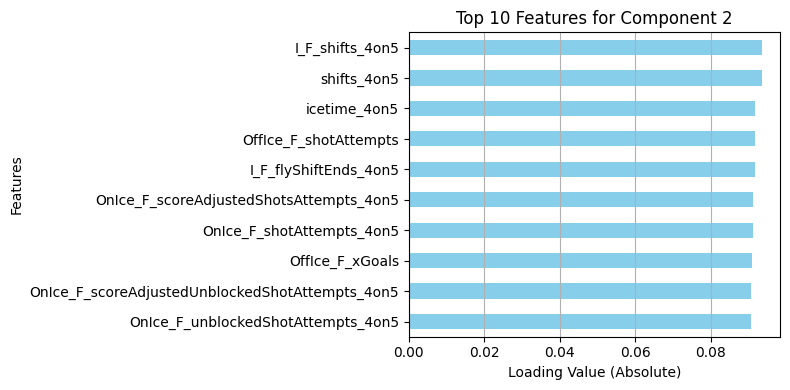

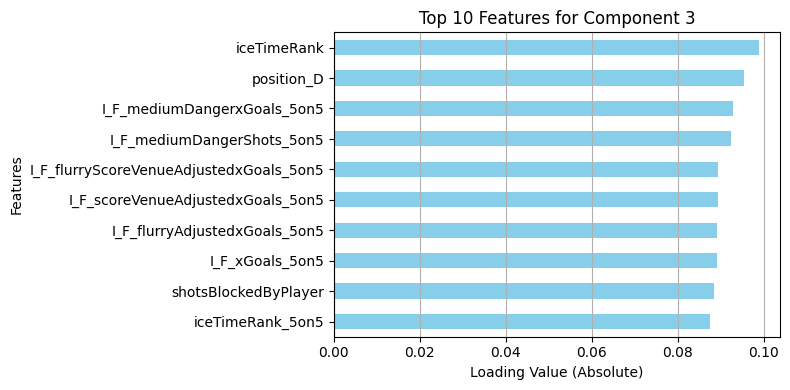

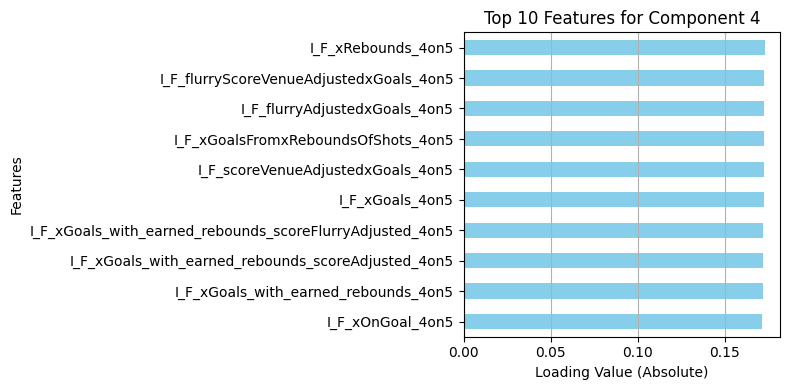

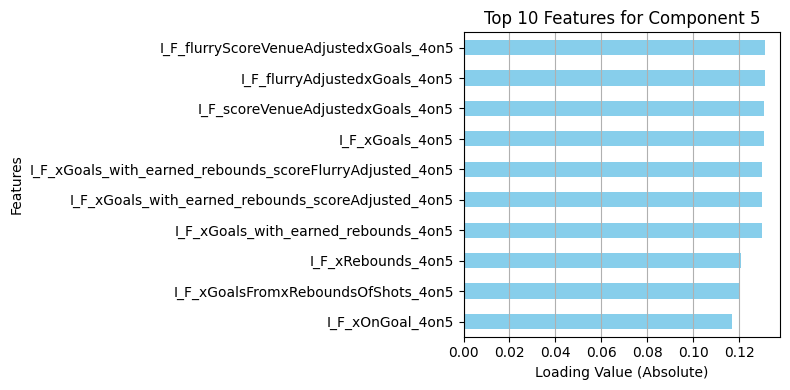

In [6]:
n_top_features = 10

loadings_df = pd.DataFrame(P, index=X_data.columns)

for comp in range(5):
    plt.figure(figsize=(8, 4))
    # Sort features by absolute loading values for the current component
    top_features = loadings_df.iloc[:, comp].abs().nlargest(n_top_features)
    
    # Plot
    top_features.sort_values().plot(kind='barh', color='skyblue')
    plt.title(f"Top {n_top_features} Features for Component {comp + 1}")
    plt.xlabel("Loading Value (Absolute)")
    plt.ylabel("Features")
    plt.grid(axis='x')
    plt.tight_layout()
    plt.show()

## Sklearn PLS

In [7]:
results = []
for n in n_components:
    pls = PLSRegression(n_components=n)
    X_train_pls = pls.fit_transform(X_train, y_train)[0]
    X_test_pls = pls.transform(X_test)

    # Train and evaluate the models
    results_df, predictions = common.train_and_evaluate(X_train_pls, y_train, X_test_pls, y_test)

    results_df["Components"] = n

    results.append(results_df)

results_df = pd.concat(results)
results_df.groupby(by="Components")[results_df.columns].apply(lambda x: x).drop(columns=["Components"])

R2        MAE Top-100 MAE Top-50 MAE  \
Components Model                                                           
5          Linear Regression    0.5871  1,301,688   1,884,016  2,420,104   
           Random Forest        0.5704  1,315,768   1,992,715  2,591,870   
           Support Vector       0.5913  1,291,255   1,909,250  2,449,940   
           K-Nearest Neighbors  0.5595  1,336,533   1,888,610  2,421,002   
10         Linear Regression    0.5733  1,325,284   1,842,915  2,280,512   
           Random Forest        0.5710  1,325,692   1,881,152  2,547,652   
           Support Vector       0.5764  1,318,906   1,856,640  2,304,904   
           K-Nearest Neighbors  0.5742  1,299,178   1,816,722  2,283,583   
25         Linear Regression    0.5345  1,377,533   1,772,794  2,163,478   
           Random Forest        0.5631  1,365,039   1,944,955  2,570,970   
           Support Vector       0.5471  1,363,322   1,785,004  2,191,026   
           K-Nearest Neighbors  0.5745  1,313,526   1,820,760  2,294,476   
50         Linear Regression    0.5159  1,407,256   1,916,936  2,332,747   
           Random Forest        0.5308  1,435,212   2,150,801  2,850,166   
           Support Vector       0.5435  1,371,151   1,854,169  2,272,515   
           K-Nearest Neighbors  0.5711  1,323,524   1,814,138  2,353,707   
100        Linear Regression    0.5101  1,416,501   1,888,406  2,281,440   
           Random Forest        0.4905  1,509,033   2,322,325  3,109,303   
           Support Vector       0.5378  1,385,282   1,850,568  2,273,441   
           K-Nearest Neighbors  0.5873  1,294,146   1,837,739  2,357,288   
200        Linear Regression    0.5051  1,435,270   1,967,415  2,346,021   
           Random Forest        0.4440  1,585,455   2,402,792  3,258,788   
           Support Vector       0.5346  1,390,313   1,911,683  2,342,793   
           K-Nearest Neighbors  0.5817  1,299,766   1,812,803  2,356,020   

                                 SMAPE  Train time (sec)  
Components Model                                          
5          Linear Regression    0.3348              0.00  
           Random Forest        0.3373              1.04  
           Support Vector       0.3304              0.41  
           K-Nearest Neighbors  0.3438              0.00  
10         Linear Regression    0.3386              0.00  
           Random Forest        0.3376              1.43  
           Support Vector       0.3357              0.37  
           K-Nearest Neighbors  0.3311              0.00  
25         Linear Regression    0.3490              0.00  
           Random Forest        0.3468              2.40  
           Support Vector       0.3439              0.65  
           K-Nearest Neighbors  0.3346              0.00  
50         Linear Regression    0.3609              0.02  
           Random Forest        0.3654              3.23  
           Support Vector       0.3484              0.54  
           K-Nearest Neighbors  0.3379              0.00  
100        Linear Regression    0.3647              0.06  
           Random Forest        0.3836              4.64  
           Support Vector       0.3522              0.68  
           K-Nearest Neighbors  0.3292              0.00  
200        Linear Regression    0.3679              0.07  
           Random Forest        0.4003              6.79  
           Support Vector       0.3532              1.06  
           K-Nearest Neighbors  0.3308              0.00

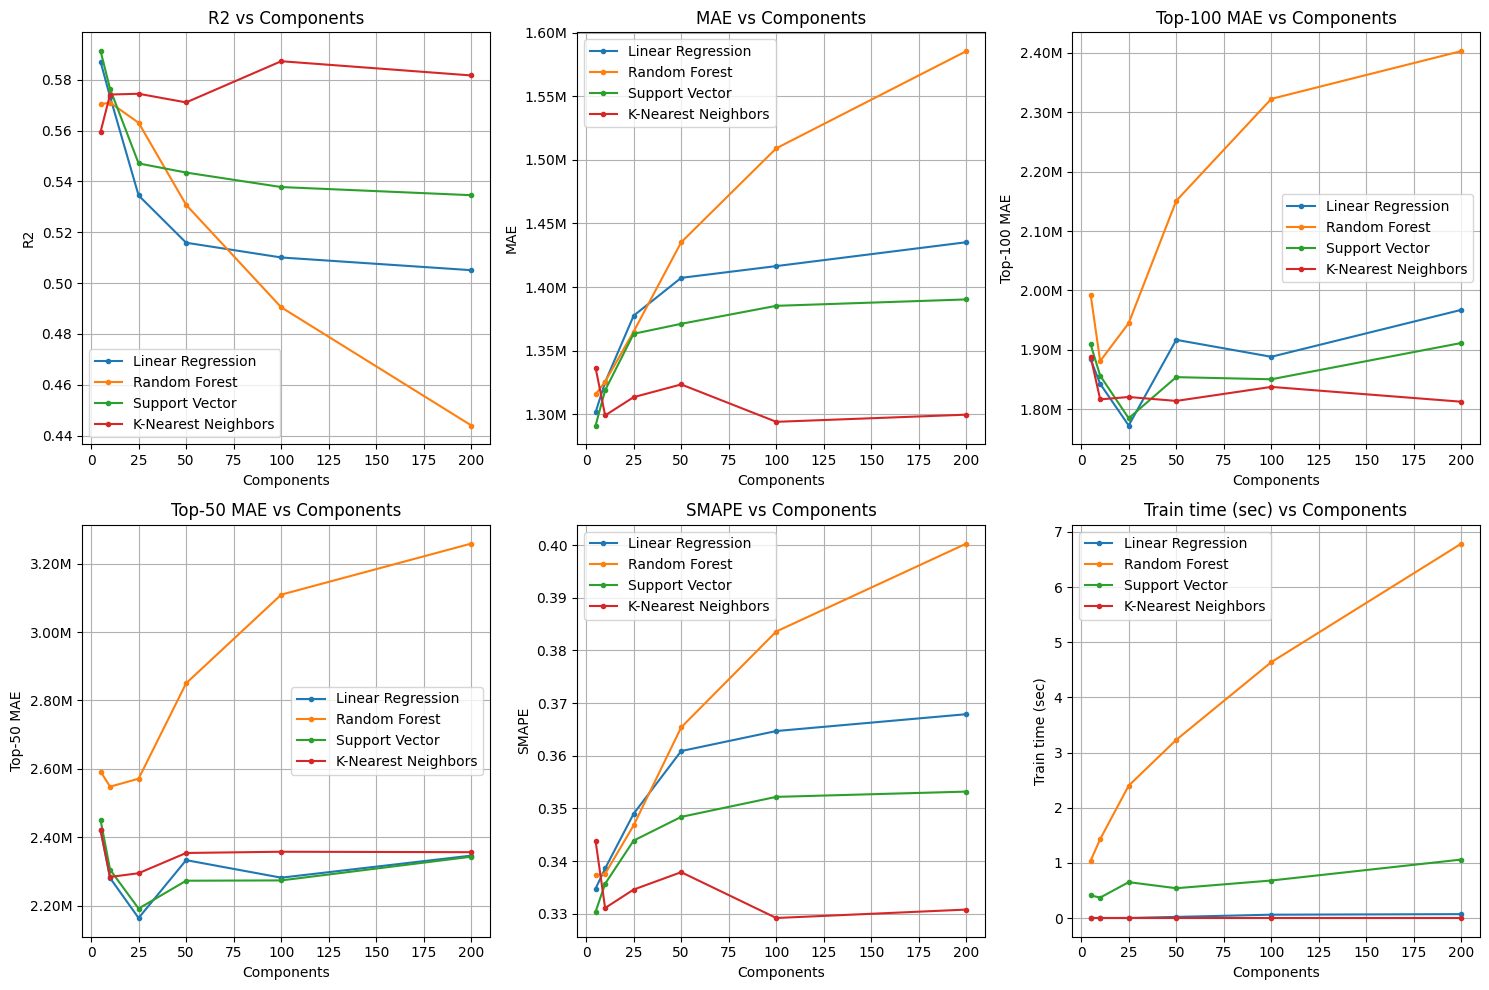

In [8]:
common.plot_metrics(results_df, "Components")